In [1]:
import sys
!{sys.executable} -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [2]:
import os
import time
from tempfile import TemporaryDirectory

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

cudnn.benchmark = True

In [3]:
def get_default_device():
    cuda = torch.cuda.is_available()
    mps = torch.backends.mps.is_available()
    print(cuda, mps)

    if cuda:
        return torch.device("cuda")
    if mps:
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [4]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
# os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [5]:
device = get_default_device()
device

True False


device(type='cuda')

In [6]:
# plt.rcParams["axes.unicode_minus"] = False
# fontprop = fm.FontProperties(fname="/usr/share/fonts/truetype/malgun.ttf")

## 데이터 로딩


In [7]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

In [8]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            #             transforms.Normalize(mean, std),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            #         transforms.Normalize(mean, std)
        ]
    ),
}

In [9]:
data_dir = "./data/ResNet18"
os.listdir(data_dir)

['val', 'train']

In [10]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                            transform=data_transforms[x])
    for x in ["train", "val"]
}

image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 687
     Root location: ./data/ResNet18/train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 139
     Root location: ./data/ResNet18/val
     StandardTransform
 Transform: Compose(
                ToTensor()
            )}

In [11]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=64, shuffle=True, num_workers=8
    )
    for x in ["train", "val"]
}

dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f07758a8590>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f07758961d0>}

In [12]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
dataset_sizes

{'train': 687, 'val': 139}

In [13]:
class_names = image_datasets["train"].classes
class_names

['Negative', 'Neutral', 'Positive']

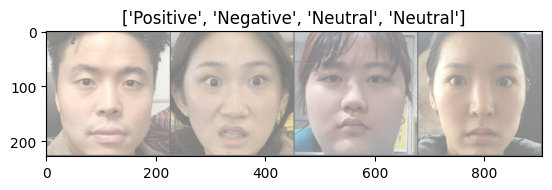

In [14]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## Training


In [15]:
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_params_path = "./models/ResNet18/resnet18_best_model_params.pth"

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "train":
                train_loss_history.append(float(epoch_loss))
                train_acc_history.append(float(epoch_acc))
            else:
                val_loss_history.append(float(epoch_loss))
                val_acc_history.append(float(epoch_acc))
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model

## Visualizing the model predictions


In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axes = plt.subplots(
        2, 3, figsize=(5, 3), dpi=200, sharex=True, sharey=True, constrained_layout=True
    )

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                q, r = divmod(images_so_far, 3)
                images_so_far += 1

                axes[q][r].set_title(
                    f"label: {class_names[labels.data[j]]}\npredicted: {class_names[preds[j]]}"
                )
                axes[q][r].imshow(inputs.cpu().data[j].permute(1, 2, 0).numpy())

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet


In [17]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer_ft = optim.RMSProp(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate


In [18]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50
)

Epoch 1/50
----------
train Loss: 0.8290 Acc: 0.6463
val Loss: 1.5761 Acc: 0.6115

Epoch 2/50
----------
train Loss: 0.4412 Acc: 0.8180
val Loss: 2.7723 Acc: 0.5396

Epoch 3/50
----------
train Loss: 0.2922 Acc: 0.8763
val Loss: 0.8589 Acc: 0.7410

Epoch 4/50
----------
train Loss: 0.1733 Acc: 0.9316
val Loss: 0.6196 Acc: 0.7482

Epoch 5/50
----------
train Loss: 0.1308 Acc: 0.9534
val Loss: 0.4953 Acc: 0.8273

Epoch 6/50
----------
train Loss: 0.1039 Acc: 0.9651
val Loss: 0.5310 Acc: 0.8058

Epoch 7/50
----------
train Loss: 0.0871 Acc: 0.9738
val Loss: 0.8402 Acc: 0.7338

Epoch 8/50
----------
train Loss: 0.0374 Acc: 0.9898
val Loss: 0.5428 Acc: 0.8345

Epoch 9/50
----------
train Loss: 0.0156 Acc: 1.0000
val Loss: 0.5130 Acc: 0.8417

Epoch 10/50
----------
train Loss: 0.0160 Acc: 0.9985
val Loss: 0.4808 Acc: 0.8345

Epoch 11/50
----------
train Loss: 0.0136 Acc: 0.9985
val Loss: 0.4398 Acc: 0.8417

Epoch 12/50
----------
train Loss: 0.0075 Acc: 1.0000
val Loss: 0.4032 Acc: 0.8345

E

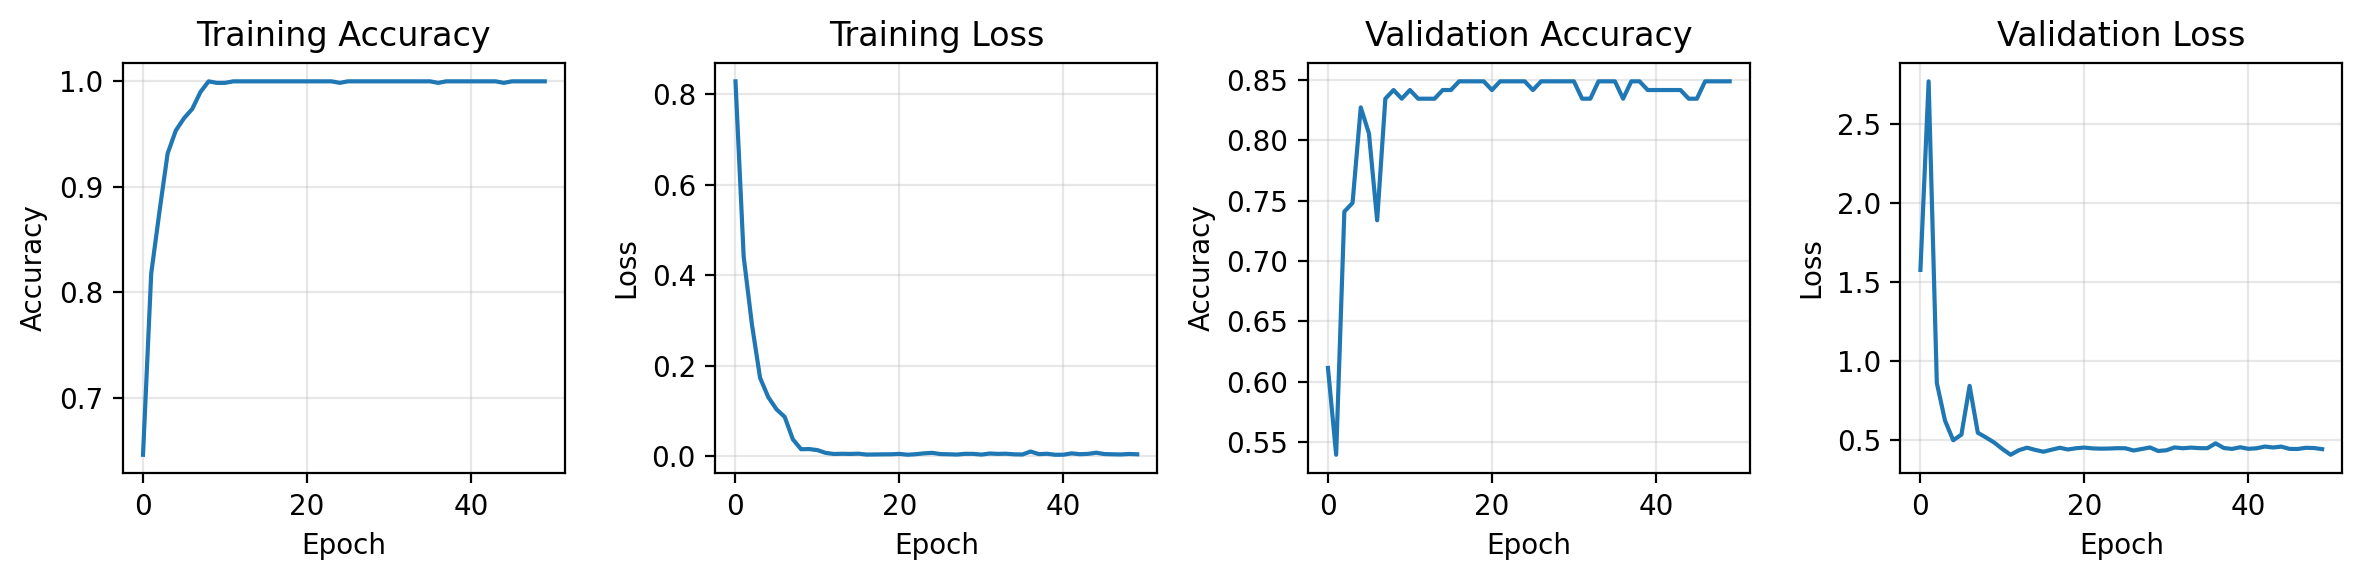

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3), dpi=200)

axes[0].set_title("Training Accuracy")
axes[0].plot(range(len(train_acc_history)), train_acc_history, label="Train Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, alpha=0.3)

axes[1].set_title("Training Loss")
axes[1].plot(range(len(train_loss_history)), train_loss_history, label="Train Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True, alpha=0.3)

axes[2].set_title("Validation Accuracy")
axes[2].plot(range(len(val_acc_history)), val_acc_history, label="Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy")
axes[2].grid(True, alpha=0.3)

axes[3].set_title("Validation Loss")
axes[3].plot(range(len(val_loss_history)), val_loss_history, label="Validation Loss")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Loss")
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close(fig)

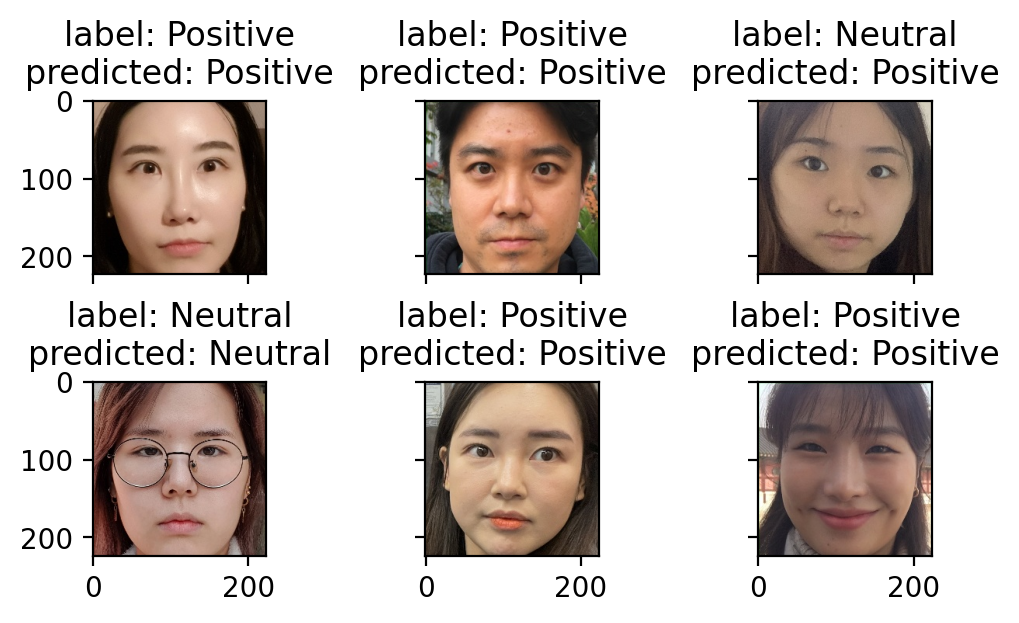

In [20]:
visualize_model(model_ft)